In [53]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import fminbound
from quantecon import tauchen

# to print plots inline
%matplotlib inline

In [3]:
γ = 0.5
β = 0.96
δ = 0.05
α = 0.4
ρ = 0.8
σ_v = 0.1
N = 100
size_v = 3

In [4]:
def utility(k, kprime, z, γ, α, δ):
    C = (1 - δ) * k + z * k ** α - kprime
    U = (C ** (1 - γ)) / (1 - γ)
    return U

In [5]:
'''
------------------------------------------------------------------------
Create Grid for State Space    
------------------------------------------------------------------------
lb_k      = scalar, lower bound of capital grid
ub_k      = scalar, upper bound of capital grid 
size_k    = integer, number of grid points in capital state space
k_grid    = vector, size_k x 1 vector of capital grid points 
------------------------------------------------------------------------
'''
lb_k = 0.4
ub_k = 100
size_k = 200  # Number of grid points
k_grid = np.linspace(lb_k, ub_k, size_k)

In [6]:
# write Bellman operator function to help with VFI
def bellman_operator(V, k_grid, β, z, γ, α, δ):
    '''
    The approximate Bellman operator, which computes and returns the
    updated value function TV on the grid points.  An array to store
    the new set of values TV is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.
    '''
    
    # Apply cubic interpolation to V
    V_func = interpolate.interp1d(k_grid, V, kind='cubic', fill_value='extrapolate')

    # Initialize array for operator and policy function
    TV = np.empty_like(V)
    optK = np.empty_like(TV)

    # == set TV[i] = max_w' { u(w,w') + beta V(w')} == #
    for i, k in enumerate(k_grid):
        def objective(kprime):
            return - utility(k, kprime, z.mean(), γ, α, δ) - β * V_func(kprime)
            
        kprime_star = fminbound(objective, 1e-6, k - 1e-6)
        optK[i] = kprime_star
        TV[i] = - objective(kprime_star)
    return TV, optK

In [42]:
def solve_VF(V, k_grid, β, z, γ, α, δ):
    VFtol = 1e-3
    VFdist = 7.0 
    VFmaxiter = 500 
    V = np.zeros(size_k)#true_VF # initial guess at value function
    VFiter = 1 
    while VFdist > VFtol and VFiter < VFmaxiter:
        TV, optK = bellman_operator(V, k_grid, β, z.mean(), γ, α, δ)
        VFdist = (np.absolute(V - TV)).max()  # check distance
        V = TV
        VFiter += 1

    if VFiter < VFmaxiter:
        print('Value function converged after this many iterations:', VFiter)
    else:
        print('Value function did not converge')
    optC = k_grid * (1 - δ) + z.mean() * k_grid ** α - optK
        
    return V, optC, optK

In [43]:
V = np.zeros(size_k)#true_VF # initial guess at value function
markov = tauchen(ρ, σ_v, n=size_v)
VF = np.zeros((size_k, size_v))
C = np.zeros((size_k, size_v))
K = np.zeros((size_k, size_v))

for i in range(size_v):
    z = np.exp(markov.simulate(N, init=markov.state_values[i]))
    VF[:, i], C[:, i], K[:, i] = solve_VF(V, k_grid, β, z, γ, α, δ)

Value function converged after this many iterations: 194
Value function converged after this many iterations: 194
Value function converged after this many iterations: 197


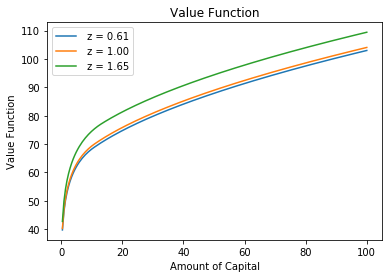

In [70]:
for i in range(size_v):
    plt.plot(k_grid, VF[:, i], label=f' z = {np.exp(markov.state_values[i]):.2f}')
plt.xlabel('Amount of Capital')
plt.ylabel('Value Function')
plt.title('Value Function')
plt.legend()
plt.show()

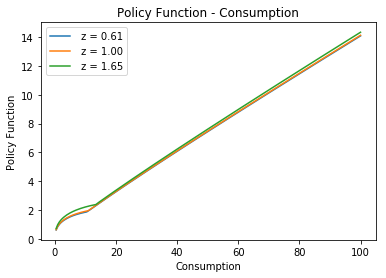

In [71]:
for i in range(size_v):
    plt.plot(k_grid, C[:, i], label=f' z = {np.exp(markov.state_values[i]):.2f}')
plt.xlabel('Consumption')
plt.ylabel('Policy Function')
plt.title('Policy Function - Consumption')
plt.legend()
plt.show()

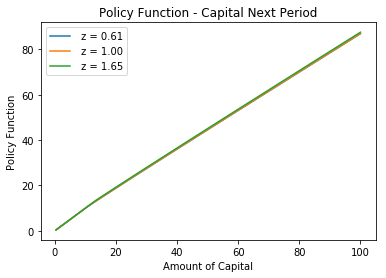

In [72]:
for i in range(size_v):
    plt.plot(k_grid, K[:, i], label=f' z = {np.exp(markov.state_values[i]):.2f}')
plt.xlabel('Amount of Capital')
plt.ylabel('Policy Function')
plt.title('Policy Function - Capital Next Period')
plt.legend()
plt.show()